In [1]:
!nvidia-smi

Tue Apr 15 12:47:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2025-04-15 12:47:19.995333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744721240.255725      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744721240.331626      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Setting parameters
path = "/kaggle/input/satellite-image-classification/data"  # Update this to your data path
batch_size = 32
height = 72
width = 128


In [4]:
# Loading and splitting dataset
train = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=(height, width),
    batch_size=batch_size)

val = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=(height, width),
    batch_size=batch_size)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.


I0000 00:00:1744721259.045466      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744721259.046129      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [5]:
# Data augmentation for better model performance
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

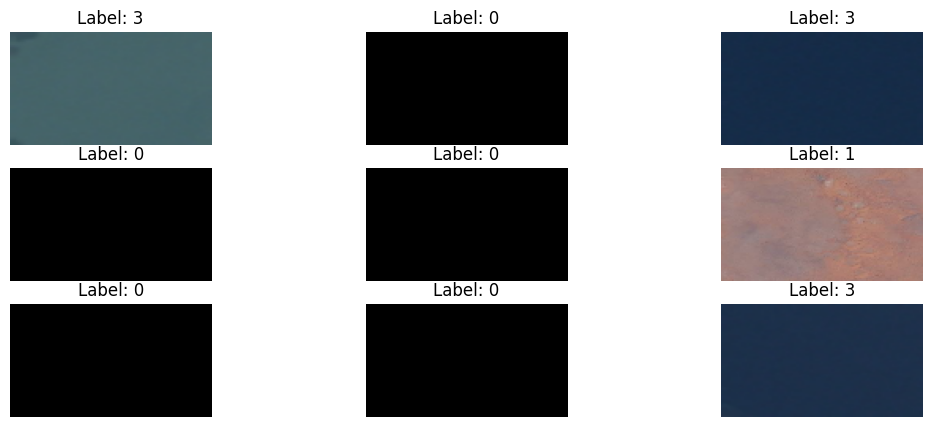

In [6]:
# Display sample images
plt.figure(figsize=(13, 5))
for i, (images, labels) in enumerate(train.take(1)):
    for j in range(9):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")
plt.show()

In [7]:
# Get number of classes
class_names = train.class_names
amount = len(class_names)
print(f"There are {amount} different Classes: {class_names}")

# Create dictionary for class mapping
classes = {i: name for i, name in enumerate(class_names)}

There are 4 different Classes: ['cloudy', 'desert', 'green_area', 'water']


In [8]:
# Improve performance with buffer and prefetch
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Apply data augmentation to the training set
train_ds = train.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
# Build an improved CNN model
model = Sequential([
    layers.Input(shape=(height, width, 3)),
    layers.Rescaling(1./255),
    
    # First convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    # Second convolutional block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    
    # Third convolutional block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    
    # Fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(amount)
])


In [11]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [12]:
# Create callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

In [13]:
# Train model with callbacks
epochs = 30  # Set higher epochs since we have early stopping
history = model.fit(
    train_ds,
    validation_data=val,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


I0000 00:00:1744721274.196693      69 service.cc:148] XLA service 0x78574403e1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744721274.200321      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744721274.200346      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744721274.835627      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5521 - loss: 1.3550  

I0000 00:00:1744721283.161494      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.8531 - loss: 0.4296 - val_accuracy: 0.2735 - val_loss: 5.2448 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9039 - loss: 0.2387 - val_accuracy: 0.2735 - val_loss: 5.3430 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9016 - loss: 0.2329 - val_accuracy: 0.3703 - val_loss: 1.8267 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9243 - loss: 0.1937 - val_accuracy: 0.6110 - val_loss: 3.2746 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9127 - loss: 0.2103 - val_accuracy: 0.6217 - val_loss: 0.6422 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9139 - loss: 0.1911 - val_accuracy: 0.8464 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9173 - loss: 0.1848 - v

In [14]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 72, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 72, 128, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 72, 128, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 128, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 128, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 36, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 36, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 36, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 18, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 18, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,8

 Total params: 14,582,510 (55.63 MB)

 Trainable params: 4,860,452 (18.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 9,720,906 (37.08 MB)

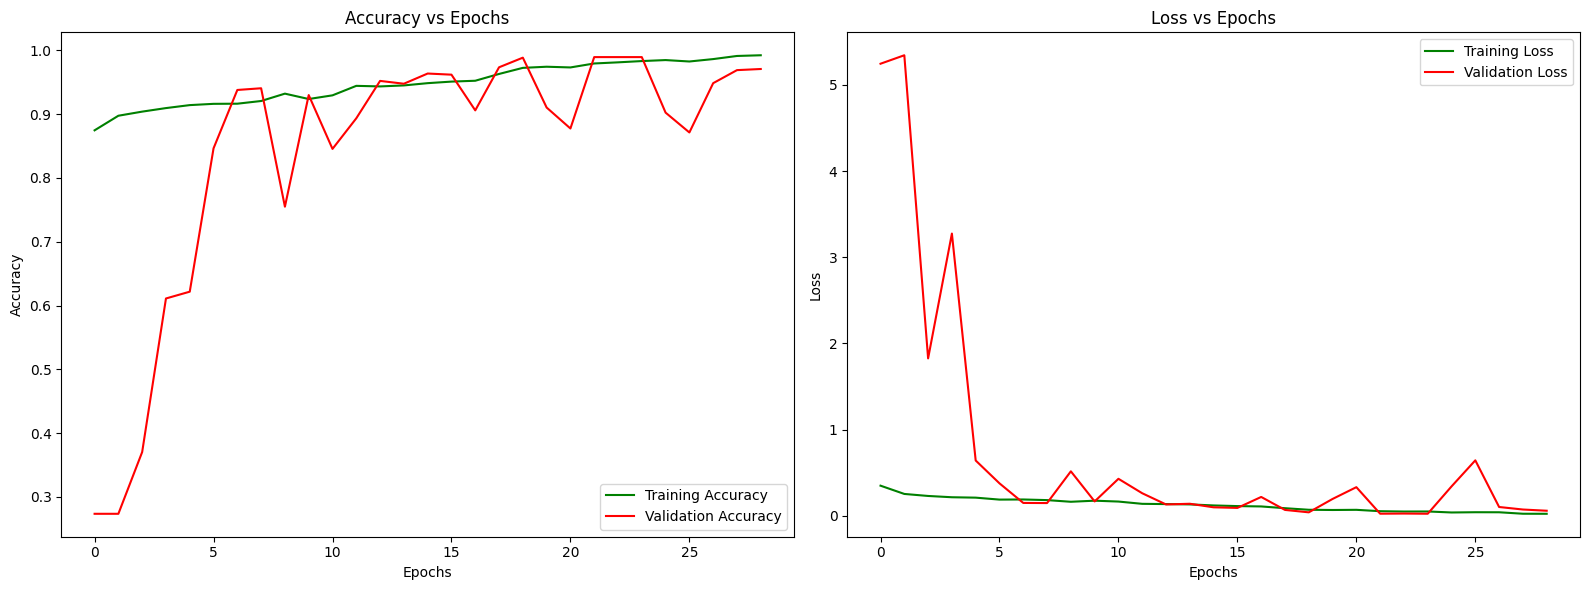

In [15]:
# Plot training performance
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='green')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
plt.legend(loc='upper right')
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [16]:
# Evaluate model on validation set
loss, accuracy = model.evaluate(val)
print(f"Validation accuracy: {accuracy:.4f}")
print(f"Validation loss: {loss:.4f}")

# Prediction visualization function
def visualize_predictions(dataset, model, num_images=4):
    plt.figure(figsize=(12, 8))
    
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(min(num_images, len(images))):
            sample_image = images[j]
            true_label = labels[j]
            
            # Get prediction
            sample_image_expanded = tf.expand_dims(sample_image, axis=0)
            predictions = model.predict(sample_image_expanded, verbose=0)
            predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
            
            # Calculate confidence
            softmax_preds = tf.nn.softmax(predictions).numpy()[0]
            confidence = softmax_preds[predicted_class_index] * 100
            
            # Plot
            plt.subplot(2, 2, j+1)
            plt.imshow(sample_image.numpy().astype("uint8"))
            color = "green" if predicted_class_index == true_label.numpy() else "red"
            plt.title(f"True: {classes[true_label.numpy()]}\nPred: {classes[predicted_class_index]} ({confidence:.1f}%)", 
                     color=color)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9893 - loss: 0.0262
Validation accuracy: 0.9893
Validation loss: 0.0247


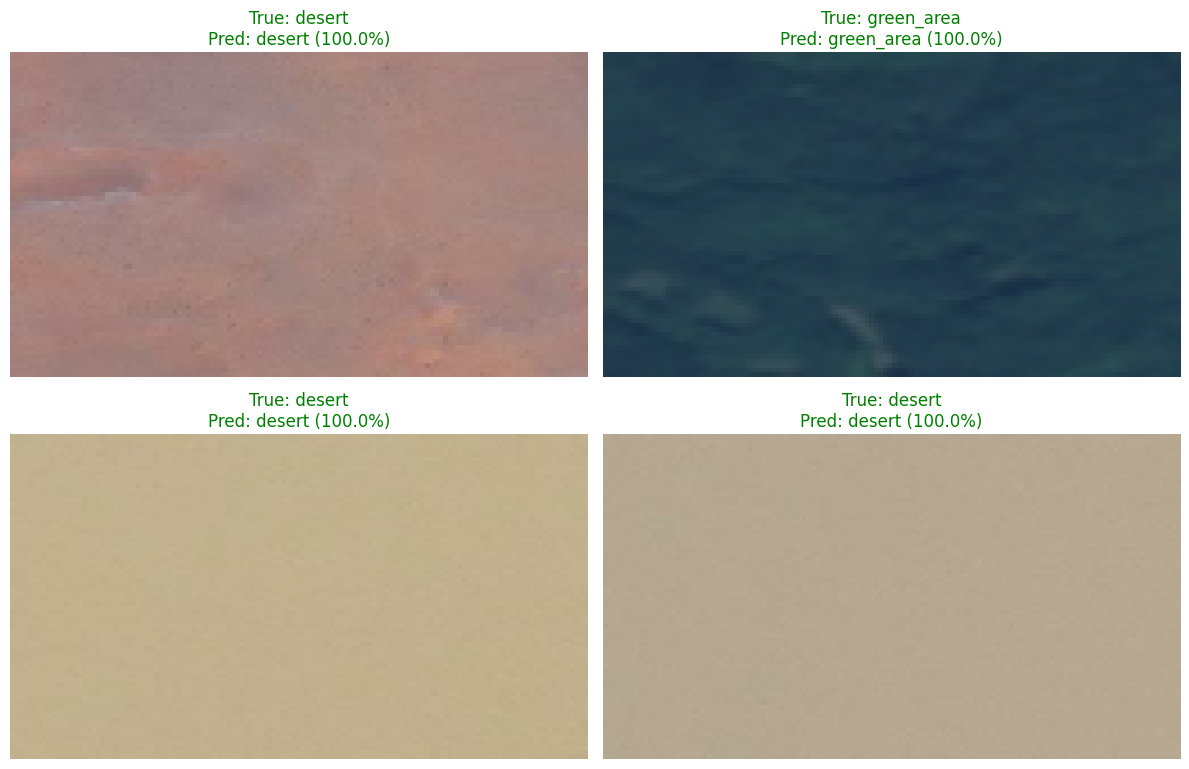

Model saved successfully


In [17]:
# Visualize some predictions
visualize_predictions(val, model)

# Save the model
model.save("satellite_classification_model.h5")
print("Model saved successfully")

Evaluating model...

----- MODEL PERFORMANCE -----
Accuracy:  0.99
Precision: 0.99
Recall:    0.99
F1 Score:  0.99


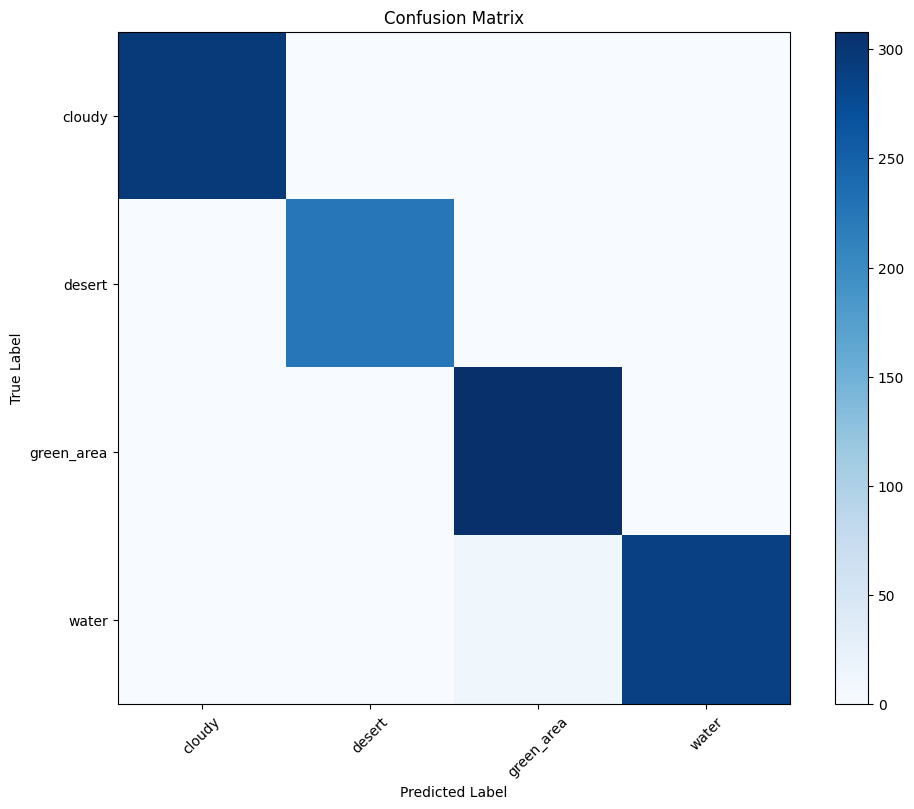

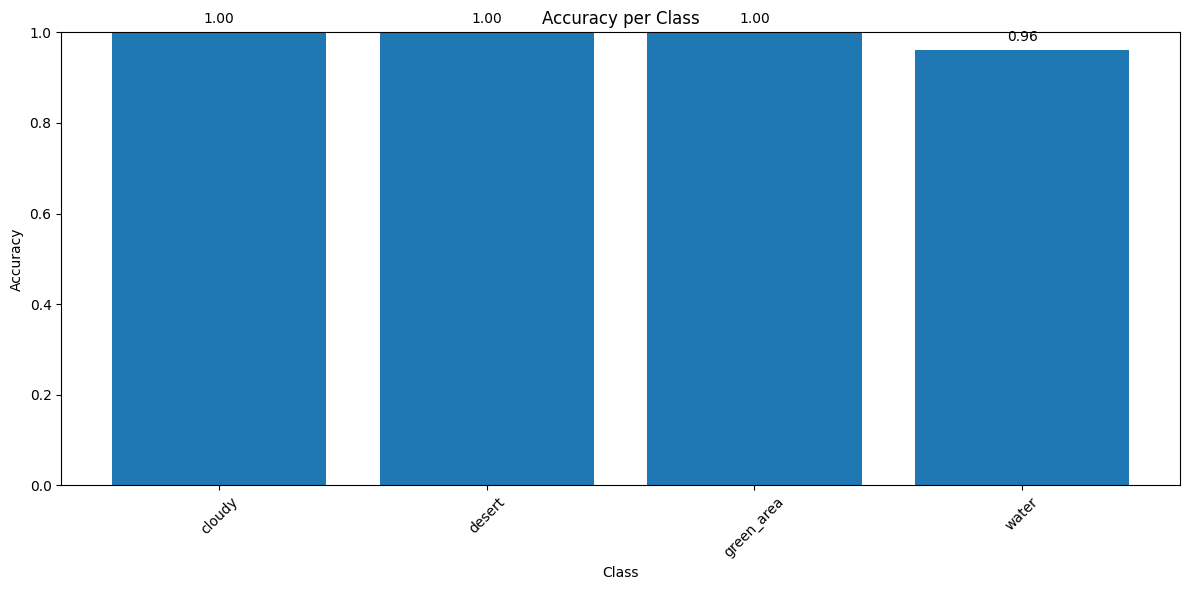


----- SUMMARY -----
The satellite image classifier achieved 99% accuracy
on the validation dataset with 4 different classes.


In [18]:
# Function for simple model evaluation
def evaluate_model_simple(model, val_dataset, class_names):
    # Collect all predictions and true labels
    y_true = []
    y_pred = []
    
    # Get predictions for validation dataset
    print("Evaluating model...")
    for images, labels in val_dataset:
        # Predict classes
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Add to lists
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes)
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    # Print simple metrics
    print("\n----- MODEL PERFORMANCE -----")
    print(f"Accuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 Score:  {f1:.2f}")
    
    # Create simple confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Display simple confusion matrix as image
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Create simple bar chart of accuracy per class
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))
    
    for true_label, pred_label in zip(y_true, y_pred):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1
    
    class_accuracy = class_correct / class_total
    
    # Plot class accuracy
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, class_accuracy)
    plt.title('Accuracy per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    for i, v in enumerate(class_accuracy):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Run the simple evaluation
results = evaluate_model_simple(model, val, class_names)

# Print a summary statement
print("\n----- SUMMARY -----")
print(f"The satellite image classifier achieved {results['accuracy']:.0%} accuracy")
print(f"on the validation dataset with {len(class_names)} different classes.")

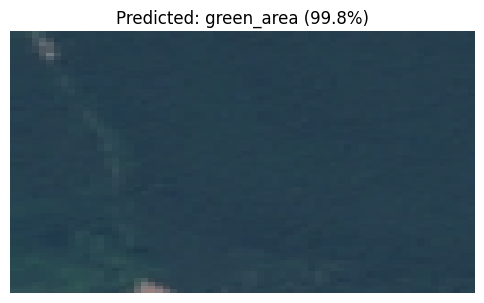

('green_area', 99.80175495147705)

In [19]:
def predict_image(image_path, model, classes):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(height, width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array, verbose=0)
    predicted_class = tf.argmax(predictions[0]).numpy()
    confidence = tf.nn.softmax(predictions[0]).numpy()[predicted_class] * 100
    
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {classes[predicted_class]} ({confidence:.1f}%)")
    plt.axis('off')
    plt.show()

    return classes[predicted_class], confidence


predict_image("/kaggle/input/satellite-image-classification/data/green_area/Forest_1949.jpg", model, classes)